In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подготовка данных

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks"

dataset.zip  Untitled0.ipynb


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/dataset"

images	masks


In [2]:
import cv2
import matplotlib.pyplot as plt
import torch
import random
from torch.utils.data import Dataset
import numpy as np
from glob import glob
import torch
from torchvision import io
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange
import pandas as pd
import seaborn as sns

In [3]:
class SelfieDataset(Dataset):
    def __init__(self, images, masks, transform=lambda t: t):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(io.read_image(str(self.images[idx])) / 255)
        mask = self.transform(io.read_image(str(self.masks[idx])) / 255)
        return image, mask

In [4]:
images = sorted(glob("/content/drive/MyDrive/Colab Notebooks/dataset/images/*"))
masks = sorted(glob("/content/drive/MyDrive/Colab Notebooks/dataset/masks/*"))

paths = list(zip(images, masks))
random.shuffle(paths)
images, masks = zip(*paths)

train_dataset = SelfieDataset(images[300:], masks[300:])
test_dataset = SelfieDataset(images[:300], masks[:300])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 1700
Test dataset length: 300


In [5]:
def show_images(image, mask):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(functional.to_pil_image(image))
    ax_l.axis("off")
    ax_r.imshow(functional.to_pil_image(mask))
    ax_r.axis("off")

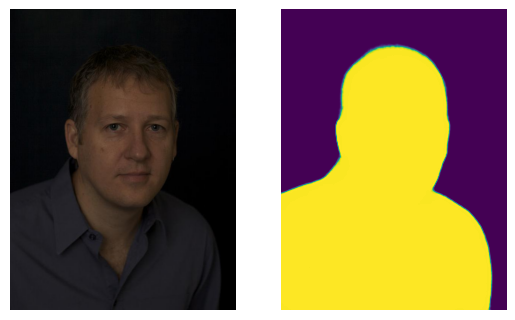

In [ ]:
image, mask = train_dataset[0]
show_images(image, mask)

In [6]:
!pip install torchmetrics  &> /dev/null
import torchmetrics

In [7]:
jaccard = torchmetrics.JaccardIndex(task="binary")

def jaccard_metric(y_pred, y_true):
    return jaccard(y_pred.cpu(), y_true.cpu() > jaccard.threshold)

In [8]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2)
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [9]:
def show_worst(model, n):
    test_metrics = []
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataset):
            pred = model(X.cuda().unsqueeze(0))[0]
            test_metrics.append((jaccard_metric(pred, y.cuda()).item(), i))

    idx = [i for _, i in sorted(test_metrics)[:n]]

    with torch.no_grad():
        for i in idx:
            X, _ = test_dataset[i]
            pred = model(X.cuda().unsqueeze(0))[0]
            show_images(X, nn.functional.sigmoid(pred))

    return idx

In [10]:
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, optimizer, loader):
    model.train()

    loss_sum = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=False):
        X = X.cuda()
        y = y.cuda()

        pred = model(X)
        loss = criterion(pred, y)
        metric = jaccard_metric(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

    return loss_sum / len(loader), metric_sum / len(loader)


def test(model, loader):
    model.eval()

    loss_sum = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=False):
            X = X.cuda()
            y = y.cuda()
            pred = model(X)
            loss_sum += criterion(pred, y).item()
            metric_sum += jaccard_metric(pred, y).item()

    return loss_sum / len(loader), metric_sum / len(loader)


def train(model, optimizer, train_loader, test_loader, epochs=20):

    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(
            model, optimizer, train_loader
        )
        loss_test, metric_test = test(model, test_loader)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]

    return model, pd.DataFrame(stats, columns=["Epoch", "Statistic", "Dataset", "Result"])


In [10]:
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, optimizer, loader):
    model.train()

    loss_sum = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=False):
        X = X
        y = y

        pred = model(X)
        loss = criterion(pred, y)
        metric = jaccard_metric(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

    return loss_sum / len(loader), metric_sum / len(loader)


def test(model, loader):
    model.eval()

    loss_sum = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=False):
            X = X
            y = y
            pred = model(X)
            loss_sum += criterion(pred, y).item()
            metric_sum += jaccard_metric(pred, y).item()

    return loss_sum / len(loader), metric_sum / len(loader)


def train(model, optimizer, train_loader, test_loader, epochs=20):

    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(
            model, optimizer, train_loader
        )
        loss_test, metric_test = test(model, test_loader)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]

    return model, pd.DataFrame(stats, columns=["Epoch", "Statistic", "Dataset", "Result"])


In [11]:
def show_result(res, plot_title = ""):
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

    sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
    ax_1.set_title("Loss")

    sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))
    ax_2.set_title("Jaccard")

    fig.suptitle(plot_title)
    fig.tight_layout()

# Кросс-валидация

Разобьем выборку на 5 фолдов

In [ ]:
from sklearn.model_selection import KFold

batch_size = 10

In [ ]:
folds = KFold(n_splits=5)
train_folds = []
test_folds = []
data = train_dataset
for fold,(train_idx,test_idx) in enumerate(folds.split(data)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=test_subsampler)
    train_folds.append(trainloader)
    test_folds.append(testloader)

In [ ]:
def folds_res(k, train_folds=train_folds, test_folds=test_folds):
    tr = train_folds[k]
    tt = test_folds[k]
    net = UNET(3, 16, 1).cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
    model, result = train(net, optimizer, tr, tt, epochs=6)
    return model, result

In [ ]:
mod1, res1 = folds_res(0)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-20-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-20-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


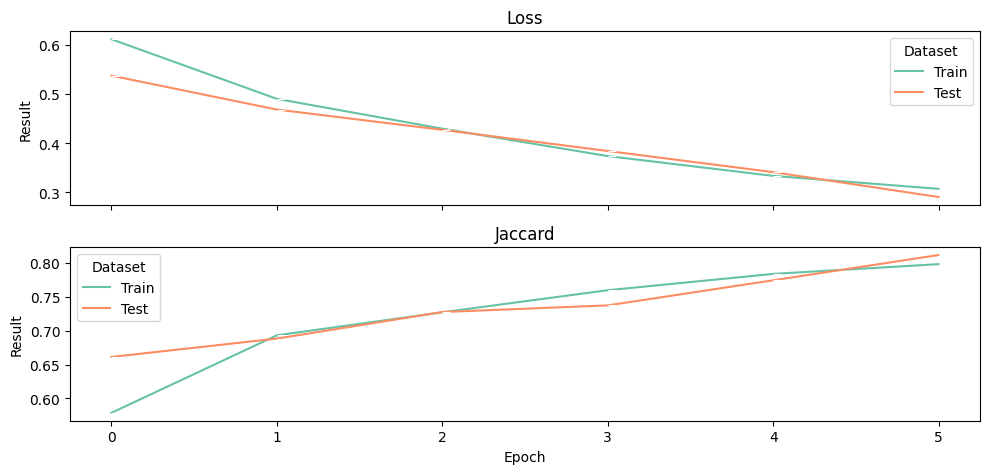

In [ ]:
show_result(res1)

[91, 261, 131]

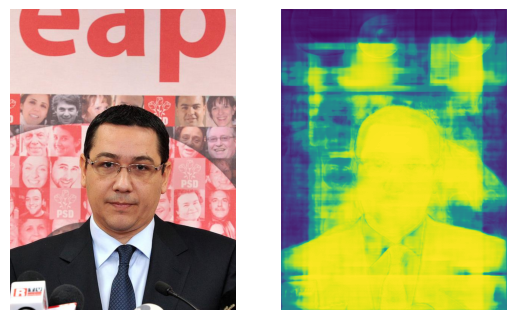

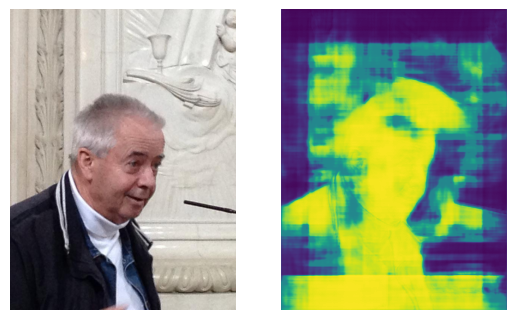

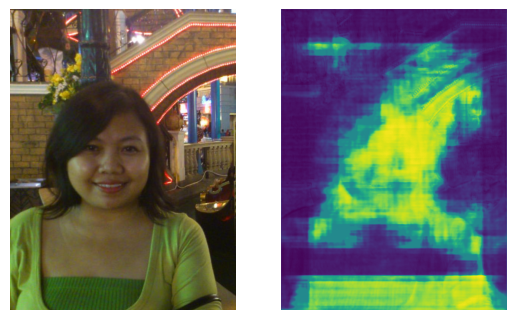

In [ ]:
show_worst(mod1, 3)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
mod2, res2 = folds_res(1)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

<ipython-input-20-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-20-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


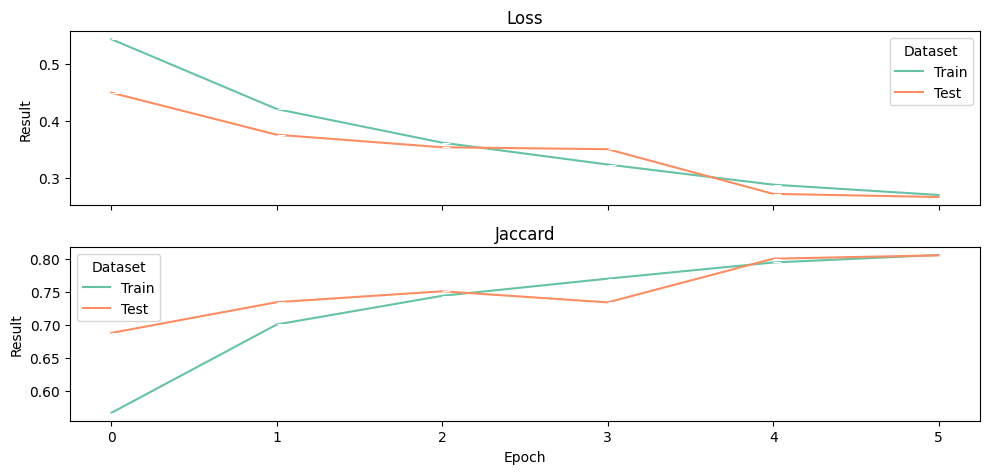

In [ ]:
show_result(res2)

[239, 131, 71]

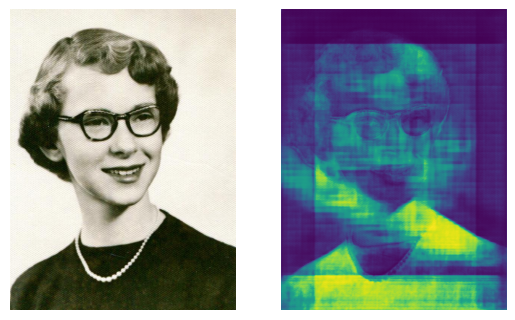

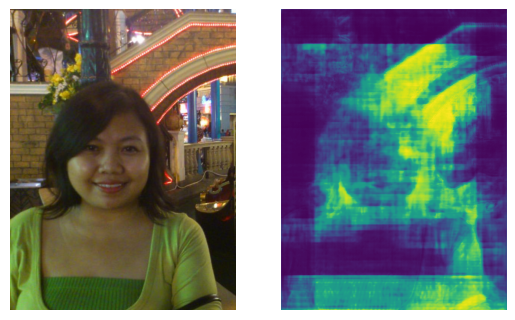

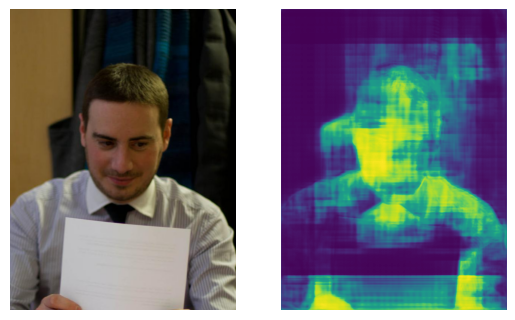

In [ ]:
show_worst(mod2, 3)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
mod3, res3 = folds_res(2)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-20-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-20-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


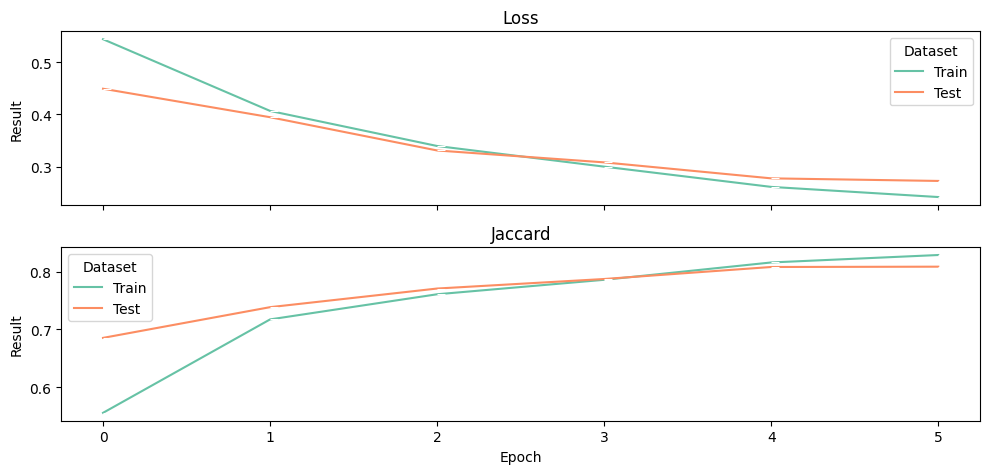

In [ ]:
show_result(res3)

[131, 217, 127]

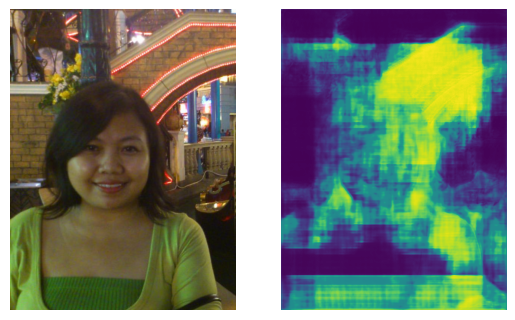

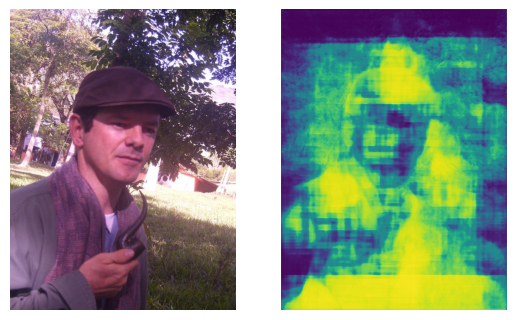

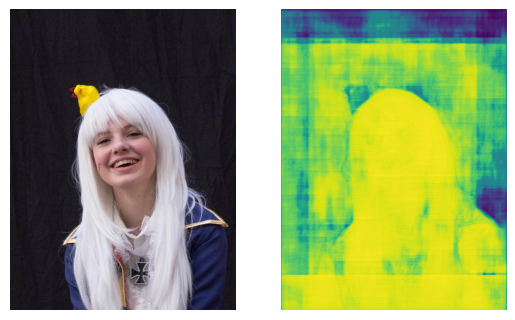

In [ ]:
show_worst(mod3, 3)

In [ ]:
mod4, res4 = folds_res(3)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-11-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-11-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


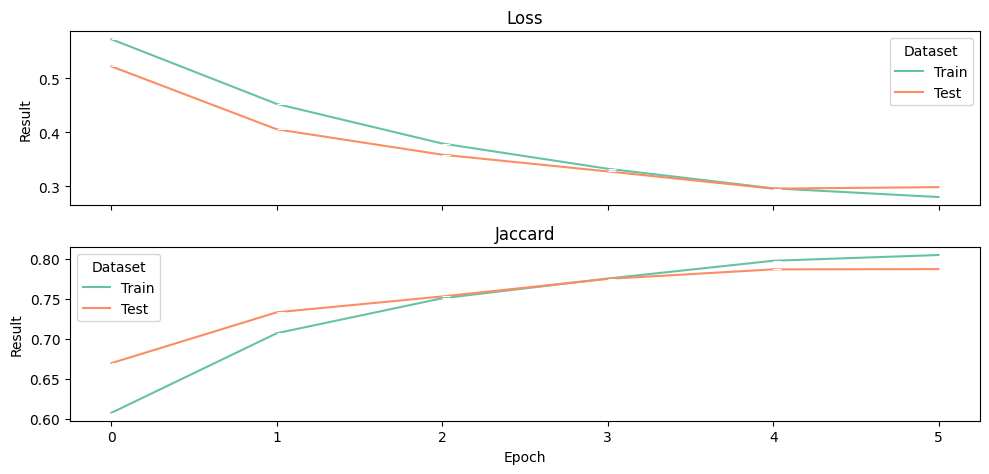

In [ ]:
show_result(res4)

[138, 89, 298]

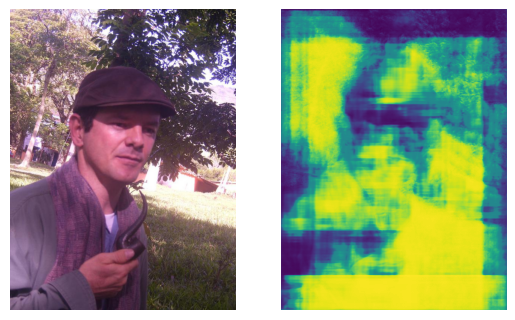

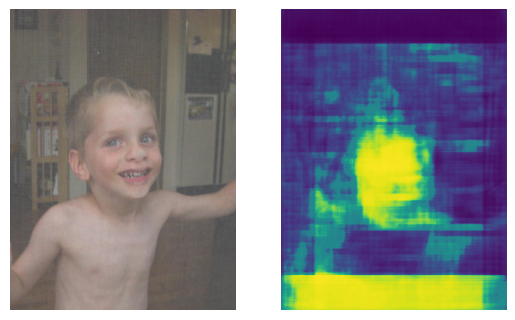

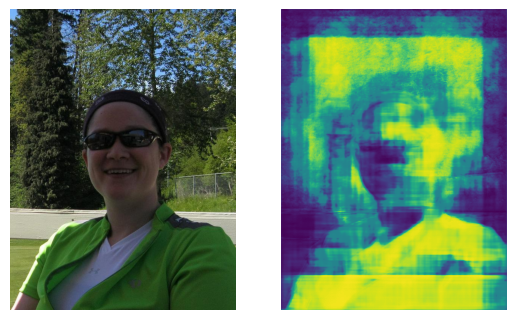

In [ ]:
show_worst(mod4, 3)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
mod5, res5 = folds_res(4)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

Training batch:   0%|          | 0/136 [00:00<?, ?it/s]

Test batch:   0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-11-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-11-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


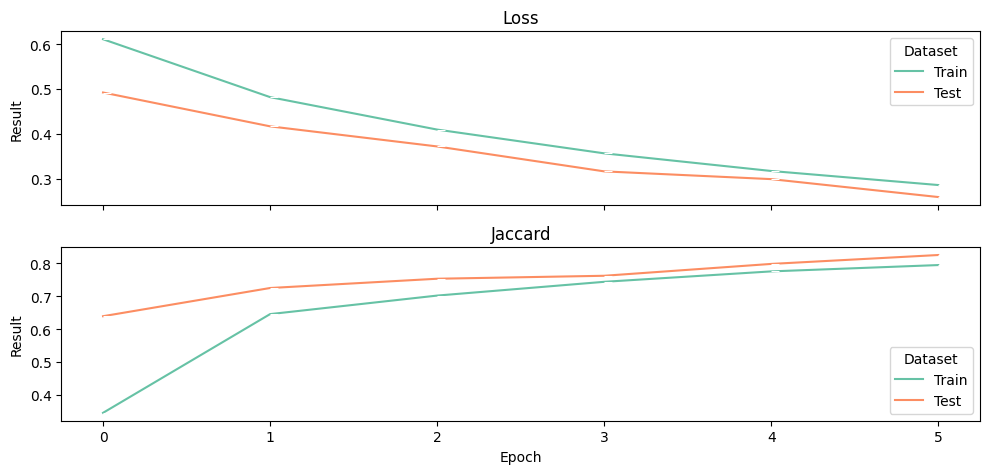

In [ ]:
show_result(res5)

[97, 138, 130]

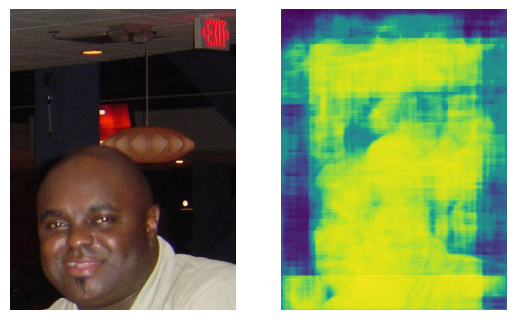

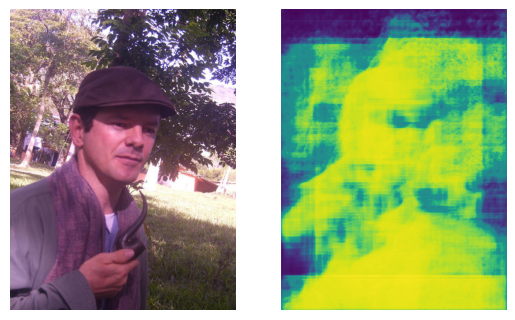

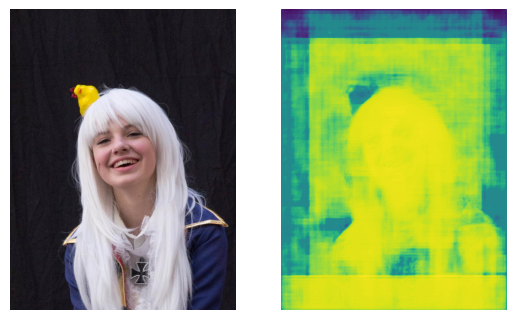

In [ ]:
show_worst(mod5, 3)

Качество всех моделей примерно одинаковое. Лучшие результаты у второй и третьей моделей. Худшие предсказания моделей пересекаются, есть общие семплы.

# Unet с pretrained энкодером

Сделаем Unet с предобученным энкодером ResNet18

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [46]:
import torch
import torch.nn as nn
import torchvision.models as models

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer1 = nn.Sequential(*self.base_layers[:3])
        self.layer2 = nn.Sequential(*self.base_layers[3:5])
        self.layer3 = self.base_layers[5]
        self.layer4 = self.base_layers[6]
        self.layer5 = self.base_layers[7]

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv6 = DoubleConv(512 + 256, 256)
        self.conv7 = DoubleConv(256 + 128, 128)
        self.conv8 = DoubleConv(128 + 64, 64)
        self.conv9 = DoubleConv(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)

        # Decoder
        x = self.upsample(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv6(x)

        x = self.upsample(x)
        dim_4 = x3.size(3) - x.size(3)
        dim_3 = x3.size(2) - x.size(2)
        if dim_4 != 0 or dim_3 != 0:
            x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
        x = torch.cat([x, x3], dim=1)
        x = self.conv7(x)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv8(x)

        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv9(x)

        x = self.final_conv(x)

        return x

In [ ]:
net = ResNetUNet(1)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

mod, res = train(net, optimizer, train_loader, test_loader, epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-11-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-11-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


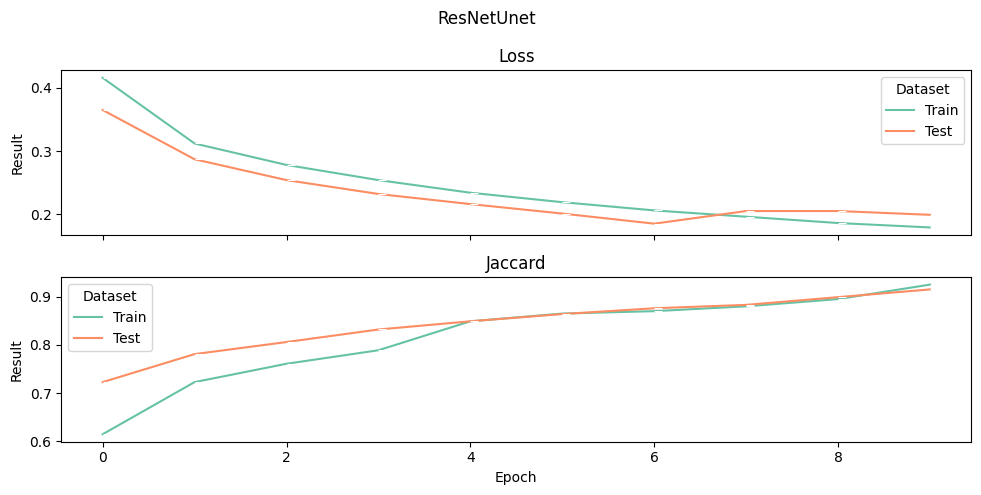

In [39]:
show_result(res, "ResNetUnet")

# Выводы

- Лучший результат показала модель с resnet энкодером
- Среди обычных unet моделей лучшие показатели у модели с аугментацией
- Модель, обученная на полном датасате немного лучше, чем модели обученные на фолдах
- Модели, обученные на фолдах, имеют практически одинаковые результаты качества
- Также они ошибаются на одних и тех же изображениях